<a href="https://colab.research.google.com/github/Bider12/Sarcasm_detecion/blob/main/sarcasm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 71 bytes


In [5]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d rmisra/news-headlines-dataset-for-sarcasm-detection

  0% 0.00/3.30M [00:00<?, ?B/s]
100% 3.30M/3.30M [00:00<00:00, 212MB/s]


In [7]:
!unzip news-headlines-dataset-for-sarcasm-detection.zip

Archive:  news-headlines-dataset-for-sarcasm-detection.zip
  inflating: Sarcasm_Headlines_Dataset.json  
  inflating: Sarcasm_Headlines_Dataset_v2.json  


In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from itertools import chain
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn import model_selection, preprocessing, linear_model, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import ensemble
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from termcolor import colored
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [9]:
df = pd.read_json(r'Sarcasm_Headlines_Dataset.json', lines=True)

In [10]:
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [11]:
df.isnull().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

In [12]:
df.shape

(26709, 3)

In [13]:
df['website'] = df.article_link.apply(lambda x: x.split('/')[2])
df.pivot_table(index = 'website', columns = 'is_sarcastic', values = 'article_link', aggfunc='count').fillna(0).astype(int)

is_sarcastic,0,1
website,,
entertainment.theonion.com,0,1194
local.theonion.com,0,2852
politics.theonion.com,0,1767
sports.theonion.com,0,100
www.huffingtonpost.com,14403,0
www.huffingtonpost.comhttp:,503,0
www.huffingtonpost.comhttps:,79,0
www.theonion.com,0,5811


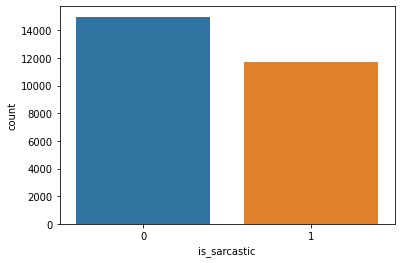

In [14]:
ax = sns.countplot(x="is_sarcastic", data=df)

In [15]:
def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='black',
                          min_font_size = 10).generate(" ".join(data.values))
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=30)
    plt.show() 

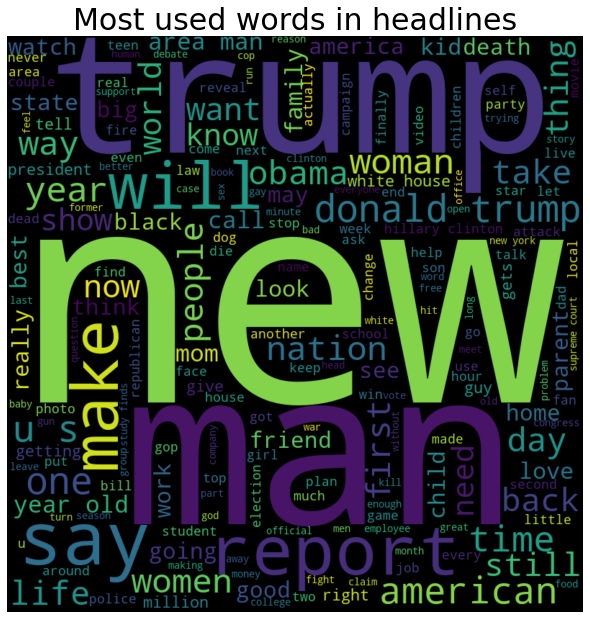

In [16]:
wordCloud_generator(df['headline'], title="Most used words in headlines")

In [17]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [18]:
stop_words = set(stopwords.words('english'))

In [19]:
print(stop_words)

{"mightn't", 'wouldn', 'these', 've', 'has', 'that', 'up', "it's", "she's", 'what', 'because', 'we', 'below', 'm', 'haven', 'their', 'theirs', 'ourselves', 'been', "hasn't", 'same', 'him', 'do', 'now', 'to', 'any', 'those', 'themselves', 'yourselves', 'and', 'during', 'her', 's', 'very', 'just', 'he', "should've", "doesn't", 'should', 'shouldn', 'there', 'be', 'i', 'why', 'more', 'shan', 'them', 'have', 'is', 'ain', 'out', 'with', 'but', 'which', 'weren', 'you', 'down', 't', 'my', 'of', 'mustn', 'yourself', 'further', 'few', 'all', 'here', 'didn', 'after', 'again', "wasn't", 'myself', "that'll", 'who', 'himself', "haven't", 'over', 'from', 'where', 'isn', 'will', 'was', "you'd", 'under', 'whom', 'hasn', 'no', 'off', 'this', 'as', 'an', 'they', 'such', 'nor', 'doesn', 'about', 'by', "you've", "aren't", 'its', 'his', 'd', "won't", 'only', 'o', 'other', 'through', 'before', "wouldn't", 'some', 'me', 'had', 'or', 'll', 'being', 'did', 'each', "mustn't", 'a', 'itself', 'once', 'mightn', 'ab

In [20]:
df['headline'] = df['headline'].apply(lambda x: ' '.join([item for item in str(x).split() if item not in stop_words]))

In [21]:
df['headline'] = df['headline'].apply(lambda x: x.lower())

In [22]:
df['headline'] = df['headline'].str.replace('[^\w\s]','')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [23]:
df['headline'] = df['headline'].str.replace('[0-9]+', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [24]:
common_top10 = pd.Series(' '.join(df['headline']).split()).value_counts()[:10]
print(common_top10)

new       1516
trump     1257
man       1250
us         567
report     515
one        514
area       484
donald     471
says       453
day        446
dtype: int64


In [25]:
sentences = df['headline'].values.tolist()
target = df['is_sarcastic'].values.tolist()

In [27]:
num_words = 1000
tokenizer = Tokenizer(num_words=num_words)

tokenizer.fit_on_texts(sentences)
tokens = tokenizer.texts_to_sequences(sentences)

numTokens = [len(token) for token in tokens]
numTokens = np.array(numTokens)
print("Tokens'mean",np.mean(numTokens))
print("Max", np.max(numTokens))
print("Argmax", np.argmax(numTokens))

Tokens'mean 3.2262533228499755
Max 14
Argmax 3848


In [28]:
X = tokenizer.texts_to_sequences(df['headline'].values)
X = pad_sequences(X)
y = pd.get_dummies(df['is_sarcastic']).values

In [29]:
max_tokens = int(np.mean(numTokens) + 2*np.std(numTokens))
padding_data = pad_sequences(tokens, maxlen=max_tokens)
print(padding_data.shape)
print(len(target))

(26709, 6)
26709


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(17895, 14) (17895, 2)
(8814, 14) (8814, 2)


In [31]:
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

In [32]:
embed_dim = 128
lstm_out = 196
max_features = 2000

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [33]:
batch_size = 32
history = model.fit(X_train, y_train, epochs = 25, batch_size=batch_size, verbose = 2)

Epoch 1/25
560/560 - 50s - loss: 0.5660 - accuracy: 0.6996 - 50s/epoch - 90ms/step
Epoch 2/25
560/560 - 44s - loss: 0.4965 - accuracy: 0.7512 - 44s/epoch - 78ms/step
Epoch 3/25
560/560 - 43s - loss: 0.4749 - accuracy: 0.7634 - 43s/epoch - 76ms/step
Epoch 4/25
560/560 - 43s - loss: 0.4612 - accuracy: 0.7717 - 43s/epoch - 77ms/step
Epoch 5/25
560/560 - 44s - loss: 0.4480 - accuracy: 0.7798 - 44s/epoch - 79ms/step
Epoch 6/25
560/560 - 43s - loss: 0.4362 - accuracy: 0.7839 - 43s/epoch - 76ms/step
Epoch 7/25
560/560 - 43s - loss: 0.4216 - accuracy: 0.7895 - 43s/epoch - 76ms/step
Epoch 8/25
560/560 - 44s - loss: 0.4066 - accuracy: 0.7976 - 44s/epoch - 79ms/step
Epoch 9/25
560/560 - 43s - loss: 0.3927 - accuracy: 0.8049 - 43s/epoch - 77ms/step
Epoch 10/25
560/560 - 43s - loss: 0.3791 - accuracy: 0.8113 - 43s/epoch - 76ms/step
Epoch 11/25
560/560 - 43s - loss: 0.3713 - accuracy: 0.8142 - 43s/epoch - 77ms/step
Epoch 12/25
560/560 - 44s - loss: 0.3563 - accuracy: 0.8211 - 44s/epoch - 79ms/step
E

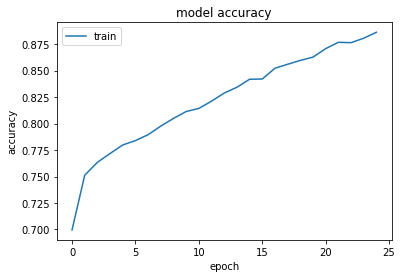

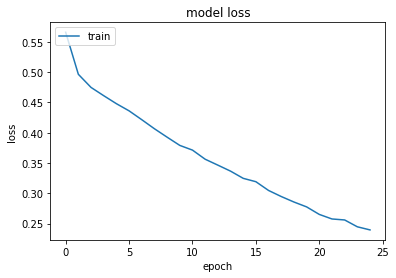

<Figure size 432x288 with 0 Axes>

In [34]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')


In [37]:
x = df["headline"]
y = df["is_sarcastic"]

train_x, test_x, train_y, test_y = model_selection.train_test_split(x, y,
                                                                    test_size = 0.20,
                                                                    shuffle = True,
                                                                    random_state = 11)

In [38]:
print(train_x.shape, test_x.shape)

(21367,) (5342,)


In [40]:
tf_idf_word_vectorizer = TfidfVectorizer(analyzer = "word")
tf_idf_word_vectorizer.fit(train_x)

x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

x_train_tf_idf_word.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [41]:
log = linear_model.LogisticRegression()
log_model = log.fit(x_train_tf_idf_word, train_y)
accuracy = model_selection.cross_val_score(log_model,
                                           x_test_tf_idf_word,
                                           test_y,
                                           cv = 20).mean()

print("\nLogistic regression model with 'tf-idf' method")
print("Accuracy ratio: ", accuracy)


Logistic regression model with 'tf-idf' method
Accuracy ratio:  0.7383000726703561


In [42]:
xgb = XGBClassifier()
xgb_model = xgb.fit(x_train_tf_idf_word,train_y)
accuracy = model_selection.cross_val_score(xgb_model,
                                           x_test_tf_idf_word,
                                           test_y,
                                           cv = 20).mean()

print("\nXGBoost model with 'tf-idf' method")
print("Accuracy ratio: ", accuracy)


XGBoost model with 'tf-idf' method
Accuracy ratio:  0.658554838168707


In [43]:
lgbm = LGBMClassifier()
lgbm_model = lgbm.fit(x_train_tf_idf_word,train_y)
accuracy = model_selection.cross_val_score(lgbm_model,
                                           x_test_tf_idf_word,
                                           test_y,
                                           cv = 20).mean()

print("\nLight GBM model with 'tf-idf' method")
print("Accuracy ratio: ", accuracy)


Light GBM model with 'tf-idf' method
Accuracy ratio:  0.664178405724188


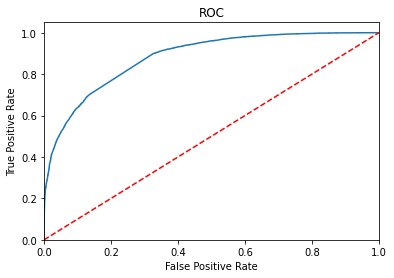

In [44]:
y = train_y
X = x_train_tf_idf_word.astype("float64")

logit_roc_auc = roc_auc_score(y, lgbm_model.predict(X))

fpr, tpr, thresholds = roc_curve(y, lgbm_model.predict_proba(X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

In [45]:
log_model.predict(x_test_tf_idf_word)[0:5]

array([0, 0, 0, 0, 0])

In [46]:
log_model.predict_proba(x_test_tf_idf_word)[0:5]

array([[0.62959548, 0.37040452],
       [0.88950894, 0.11049106],
       [0.54334147, 0.45665853],
       [0.81766398, 0.18233602],
       [0.78753766, 0.21246234]])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


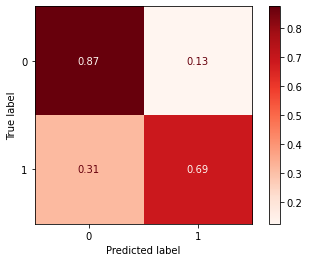

In [47]:
#plotting confusion matrix

plot_confusion_matrix(log_model, x_test_tf_idf_word, test_y,
                      cmap = plt.cm.Reds, normalize = "true");

In [48]:
print(classification_report(test_y, log_model.predict(x_test_tf_idf_word.astype("float64"))))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82      2975
           1       0.81      0.69      0.74      2367

    accuracy                           0.79      5342
   macro avg       0.79      0.78      0.78      5342
weighted avg       0.79      0.79      0.79      5342

